In [ ]:
%load_ext tensorboard
%tensorflow_version 2.x

from __future__ import print_function

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.datasets import mnist
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras import backend as K
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import h5py
from skimage.transform import resize
from skimage.color import gray2rgb
import pandas as pd
from sklearn.utils import shuffle
from numpy import load
from numpy import save

batch_size = 256
num_classes = 10
num_epochs = 10
val_size = 5000
loadModelBool = False
saveModelBool = False

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "drive/My Drive/Data/mnist_m.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/mnist_m/mnist_m_test/._00002655.png  
  inflating: mnist_m/mnist_m_test/00004224.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00004224.png  
  inflating: mnist_m/mnist_m_test/00002866.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00002866.png  
  inflating: mnist_m/mnist_m_test/00008393.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00008393.png  
  inflating: mnist_m/mnist_m_test/00000917.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00000917.png  
  inflating: mnist_m/mnist_m_test/00008387.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00008387.png  
  inflating: mnist_m/mnist_m_test/00000903.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00000903.png  
  inflating: mnist_m/mnist_m_test/00002872.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00002872.png  
  inflating: mnist_m/mnist_m_test/00007922.png  
  inflating: __MACOSX/mnist_m/mnist_m_test/._00007922.png  
  inflating: mnis

In [ ]:
def reshapeImages(images):
    images_redone = []
    for image in images:
        image = resize(image,(32,32))
        image = gray2rgb(image)
        images_redone.append(image)
    
    images = np.asarray(images_redone)
    images = images.reshape(images.shape[0], 32, 32, 3)
    images = images.astype('float32')
    images /= 255
    print(images.shape[0], 'samples')
    return (images)

def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()
    
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('#f Iterations')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def read_labeled_image_list(image_list_file):
    """Reads a .txt file containing pathes and labeles
    Args:
       image_list_file: a .txt file with one /path/to/image per line
       label: optionally, if set label will be pasted after each line
    Returns:
       List with all filenames in file image_list_file
    """
    f = open(image_list_file, 'r')
    filenames = []
    labels = []
    for line in f:
        filename, label = line[:-1].split(' ')
        filenames.append(filename)
        labels.append(int(label))
    return filenames, labels

In [ ]:
# Reads pfathes of images together with their labels
image_list, label_list = read_labeled_image_list("mnist_m/mnist_m_train_labels.txt")
mnist_m_train = pd.DataFrame(np.column_stack([image_list, label_list]), 
                               columns=['image_id', 'label'])
# data generators:
datagen = ImageDataGenerator(rescale=1./255)
train_generator_mnistm = datagen.flow_from_dataframe(
    dataframe=mnist_m_train,
    directory="mnist_m/mnist_m_train/",
    x_col='image_id',
    y_col='label',
    target_size=(32,32),
    batch_size=mnist_m_train.shape[0]
)
x_mnistm_train, y_mnistm_train = train_generator_mnistm.next()

# Reads pfathes of images together with their labels
image_list, label_list = read_labeled_image_list("mnist_m/mnist_m_test_labels.txt")
mnist_m_test = pd.DataFrame(np.column_stack([image_list, label_list]), 
                               columns=['image_id', 'label'])
# data generators:
datagen = ImageDataGenerator(rescale=1./255)
test_generator_mnistm = datagen.flow_from_dataframe(
    dataframe=mnist_m_test,
    directory="mnist_m/mnist_m_test/",
    x_col='image_id',
    y_col='label',
    target_size=(32,32),
    batch_size=mnist_m_test.shape[0]
)
x_mnistm_test, y_mnistm_test = test_generator_mnistm.next()

Found 59001 validated image filenames belonging to 10 classes.
Found 9001 validated image filenames belonging to 10 classes.


In [ ]:
# the data, split between train and test sets
# The full `train` split and the full `test` split as two distinct datasets.
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [ ]:
x_train_mnist = reshapeImages(x_train_mnist)
x_test_mnist = reshapeImages(x_test_mnist)

# convert class vectors to binary class matrices
y_train_mnist = keras.utils.to_categorical(y_train_mnist, num_classes)
y_test_mnist = keras.utils.to_categorical(y_test_mnist, num_classes)

60000 samples
10000 samples


In [ ]:
nr_of_nrs_mnistm = 10
y_train_mnistm_nrs = np.argmax(y_mnistm_train, axis=-1)
x_train_mnistm = x_mnistm_train[y_train_mnistm_nrs == 0][:nr_of_nrs_mnistm]
y_train_mnistm = y_mnistm_train[y_train_mnistm_nrs == 0][:nr_of_nrs_mnistm]
for i in range(1, 10):
  x_train_nr = x_mnistm_train[y_train_mnistm_nrs == i][:nr_of_nrs_mnistm]
  y_train_nr = y_mnistm_train[y_train_mnistm_nrs == i][:nr_of_nrs_mnistm]
  x_train_mnistm = np.vstack((x_train_mnistm, x_train_nr))
  y_train_mnistm = np.vstack((y_train_mnistm, y_train_nr))

x_train_mnistm, y_train_mnistm = shuffle(x_train_mnistm, y_train_mnistm)

In [ ]:
input1 = keras.layers.Input(shape=(32,32,3))
conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(input1)
conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu')(conv1)
maxpool1 = keras.layers.MaxPooling2D((2, 2))(conv2)
dropout1 = keras.layers.Dropout(0.1)(maxpool1)
conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(dropout1)
conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu')(conv3)
maxpool2 = keras.layers.MaxPooling2D((2, 2))(conv4)
flatten = keras.layers.Flatten()(maxpool2)
dense1 = keras.layers.Dense(200, activation='relu')(flatten)
dense2 = keras.layers.Dense(20, activation='relu')(dense1)
output = keras.layers.Dense(num_classes, activation='softmax')(dense2)

model = keras.Model(inputs=input1, outputs=[dense2,output])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928 

In [ ]:
y_train_mnist_ones = np.ones((y_train_mnist.shape[0],1))
y_train_mnist_ = np.hstack((y_train_mnist, y_train_mnist_ones))

In [ ]:
y_train_mnistm_zeros = np.zeros((y_train_mnistm.shape[0],1))
y_mnistm_train_ = np.hstack((y_train_mnistm, y_train_mnistm_zeros))

In [ ]:
# Instantiate an optimizer to train the model.
optimizer = tf.compat.v1.train.AdamOptimizer()
# Instantiate a loss function.
loss_cc = keras.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

# Prepare the training datasets
train_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([x_train_mnist, x_train_mnistm], axis=0), np.concatenate([y_train_mnist_,y_mnistm_train_],axis=0)))
train_dataset = train_dataset.shuffle(buffer_size=100000).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((np.concatenate([x_test_mnist, x_mnistm_test], axis=0), np.concatenate([y_test_mnist,y_mnistm_test],axis=0)))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
def distance_loss(predictions, y, predictions_target, y_target, classes_y):
    def some_function(tensor):
      y_source = tensor[1]
      equal =  tf.math.equal(y_source, y_target)
      equal_all = tf.reduce_all(equal, axis=1)
      contains = tf.boolean_mask(predictions_target, equal_all)
      distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(tensor[0], contains)), axis=1))
      # nearest k points
      closest_distance,_ = tf.math.top_k(tf.negative(distance), k=1)
      return tf.abs(closest_distance)
    y_equal_source =  tf.math.equal(classes_y, tf.constant(1, dtype=tf.float32))
    y_equal_all_source = tf.reduce_all(y_equal_source, axis=1)
    predictions_source = tf.boolean_mask(predictions, y_equal_all_source)
    y_source = tf.boolean_mask(y, y_equal_all_source)
    d = tf.map_fn(some_function, (predictions_source,y_source), dtype=tf.float32)
    return tf.math.reduce_sum(d)

In [ ]:
def train_step(model, optimizer, x_batch, y_batch, x_train_target, y_train_target, classes_y):

    with tf.GradientTape() as tape:   
      hidden_logits = model(x_batch, training=True)[0]
      hidden_logits_target = model(x_train_target, training=True)[0]
      loss_dist = distance_loss(hidden_logits, y_batch, hidden_logits_target, y_train_target, classes_y)
      logits = model(x_batch, training=True)[1]
      loss_cross = loss_cc(y_batch, logits)
      loss_value = loss_cross + 0.01*loss_dist

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch, logits)
    return loss_value, loss_dist, loss_cross

In [ ]:
if loadModelBool:
  model = tf.keras.models.load_model('drive/My Drive/saved_model/mnistm_model')
  dist_losses = load('drive/My Drive/Data/mnistm_model_dist_losses.npy').tolist()
  train_accuracy = load('drive/My Drive/Data/mnistm_model_train_accuracy.npy').tolist()
  cross_entropy_losses = load('drive/My Drive/Data/mnistm_model_cross_entropy_losses.npy').tolist()
  val_accuracy = load('drive/My Drive/Data/mnistm_model_val_accuracy.npy').tolist()
else: 
  dist_losses = []
  train_accuracy = []
  cross_entropy_losses = []
  val_accuracy = []

In [ ]:
for epoch in range(num_epochs):
    print('Start of epoch %d' % (epoch,))
    # Iterate over the batches of the dataset.
    step = 0

    for (x_batch, y_batch) in train_dataset:
      
      classes_y = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,-1], [y_batch.shape[0],y_batch.shape[0]], [1,1]),dtype=tf.float32)
      y_batch_ = tf.cast(tf.strided_slice(tf.identity(y_batch), [0,0], [y_batch.shape[0],-1], [1,1]),dtype=tf.float32)

      loss_value, loss_dist, loss_cross = train_step(model, optimizer, x_batch, y_batch_, tf.constant(x_train_mnistm, dtype=tf.float32), tf.constant(y_train_mnistm, dtype=tf.float32), classes_y)

      # Log every 250 batches.
      if step % 250 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Distance loss and cross entropy loss at step %s: %s  %s' % (step, float(loss_dist),float(loss_cross)))

      step +=1
    
    dist_losses.append(float(loss_dist))
    cross_entropy_losses.append(float(loss_cross))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_accuracy.append(float(train_acc))

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)[1]
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    print('Validation acc: %s' % (float(val_acc),))
    val_accuracy.append(float(val_acc))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Start of epoch 0
Training loss (for one batch) at step 0: 1.5227770805358887
Distance loss and cross entropy loss at step 0: 4.721645355224609  1.4755606651306152
Training acc over epoch: 0.5520465970039368
Validation acc: 0.3998737037181854
Start of epoch 1
Training loss (for one batch) at step 0: 1.9651122093200684
Distance loss and cross entropy loss at step 0: 2.3506860733032227  1.9416053295135498
Training acc over epoch: 0.49367719888687134
Validation acc: 0.39387401938438416
Start of epoch 2
Training loss (for one batch) at step 0: 1.9263205528259277
Distance loss and cross entropy loss at step 0: 2.18878173828125  1.904432773590088
Training acc over epoch: 0.4945257902145386
Validation acc: 0.39697909355163574


In [ ]:
if saveModelBool:
  model.save('drive/My Drive/saved_model/mnistm_model') 
  save('drive/My Drive/Data/mnistm_model_train_accuracy.npy', train_accuracy)
  save('drive/My Drive/Data/mnistm_model_dist_losses.npy', dist_losses)
  save('drive/My Drive/Data/mnistm_model_cross_entropy_losses.npy', cross_entropy_losses)
  save('drive/My Drive/Data/mnistm_model_val_accuracy.npy', val_accuracy)

INFO:tensorflow:Assets written to: drive/My Drive/saved_model/mnistm_model/assets


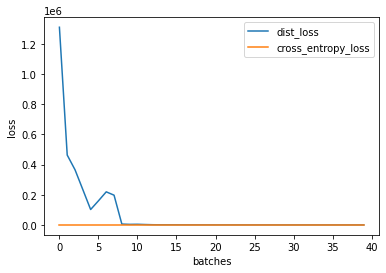

In [ ]:
plt.plot(dist_losses)
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['dist_loss', 'cross_entropy_loss'], loc='best')
plt.show()

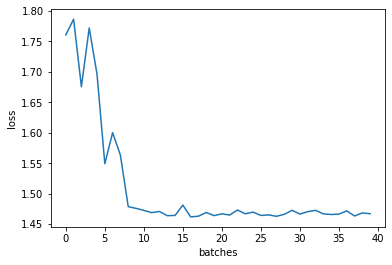

In [ ]:
plt.plot(cross_entropy_losses)
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

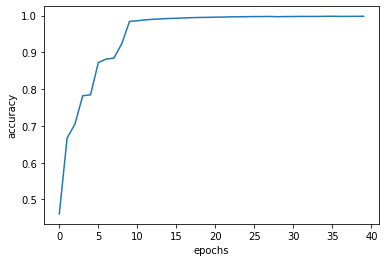

In [ ]:
plt.plot(train_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [ ]:
# retrain last layer to predict mnist digits and test on mnist-m digits
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights()) 

model_new._layers.pop()
for layer in model_new.layers: layer.trainable = False  

# recover the output from the last layer in the model and use as input to new Dense layer
last = model_new.layers[-1].output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(last)
model_new = keras.models.Model(model_new.input, output)

for layer in model_new.layers:
    print(layer, layer.trainable)

model_new.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model_new.summary()

history = model_new.fit(x_train_mnist, y_train_mnist , validation_data = (x_test_mnist, y_test_mnist), epochs=5,
    shuffle=True,
    verbose=1)

score = model_new.evaluate(x_mnistm_test, y_mnistm_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb4c473b208> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4c473b6a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4c473b710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb4c4518b38> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7fb4c4518128> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4c47327b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb4c4732a58> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fb4c44bd780> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7fb4c44bd7f0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fb4c44bd710> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fb4c46075c0> False
<tensorflow.python.keras.layers.core.Dense object at 0x7fb4c43f52e8> True
Model: "model_2"
________

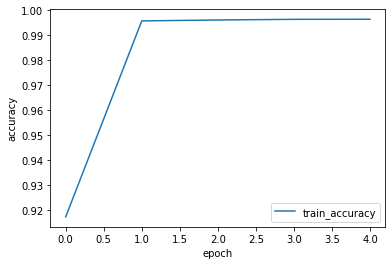

In [ ]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'], loc='best')
plt.show()